# Example Model Simulation

This notebook demonstrates how to use the model simulator to generate and analyze data.

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project directory to the path so we can import modules
sys.path.append(os.path.abspath('..'))

from src.models.simulator import ModelSimulator
from src.utils.helpers import plot_distribution, describe_with_percentiles
from src.models.beta_param_optimizer import MLModelSimulator, PerformanceTargets, BetaParameters

# Set plot style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## Linear Model Simulation

In [2]:
# Initialize simulator with random seed for reproducibility
simulator = ModelSimulator(random_seed=42)

# Generate data from a linear model
X, y = simulator.generate_linear_data(n_samples=1000, n_features=3, noise=0.5)

# Create a DataFrame for easier analysis
data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
data['target'] = y

# Display the first few rows
data.head()

,feature_0,feature_1,feature_2,target
0,0.496714,-0.138264,0.647689,-0.152718
1,1.523030,-0.234153,-0.234137,-2.329069
2,1.579213,0.767435,-0.469474,-4.146687
3,0.542560,-0.463418,-0.465730,-0.200736
4,0.241962,-1.913280,-1.724918,1.124324


In [3]:
# Analyze the generated data
describe_with_percentiles(data)

,feature_0,feature_1,feature_2,target
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.055011,-0.005969,0.046960,-0.127445
std,0.970212,1.008570,0.981119,2.112161
min,-2.940389,-3.241267,-3.019512,-6.982806
1%,-2.211936,-2.151831,-2.424386,-5.102561
5%,-1.532712,-1.570239,-1.565089,-3.731833
25%,-0.584350,-0.688545,-0.604172,-1.562371
50%,0.056832,-0.017285,0.042202,-0.107583
75%,0.664346,0.670550,0.679584,1.319031
95%,1.661670,1.674590,1.673140,3.270048


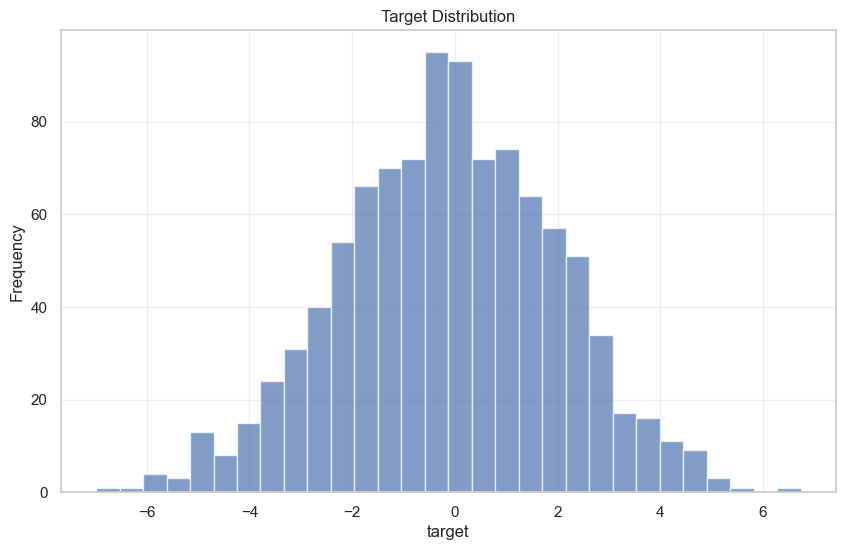

In [4]:
# Visualize the target distribution
plot_distribution(data['target'], title='Target Distribution')

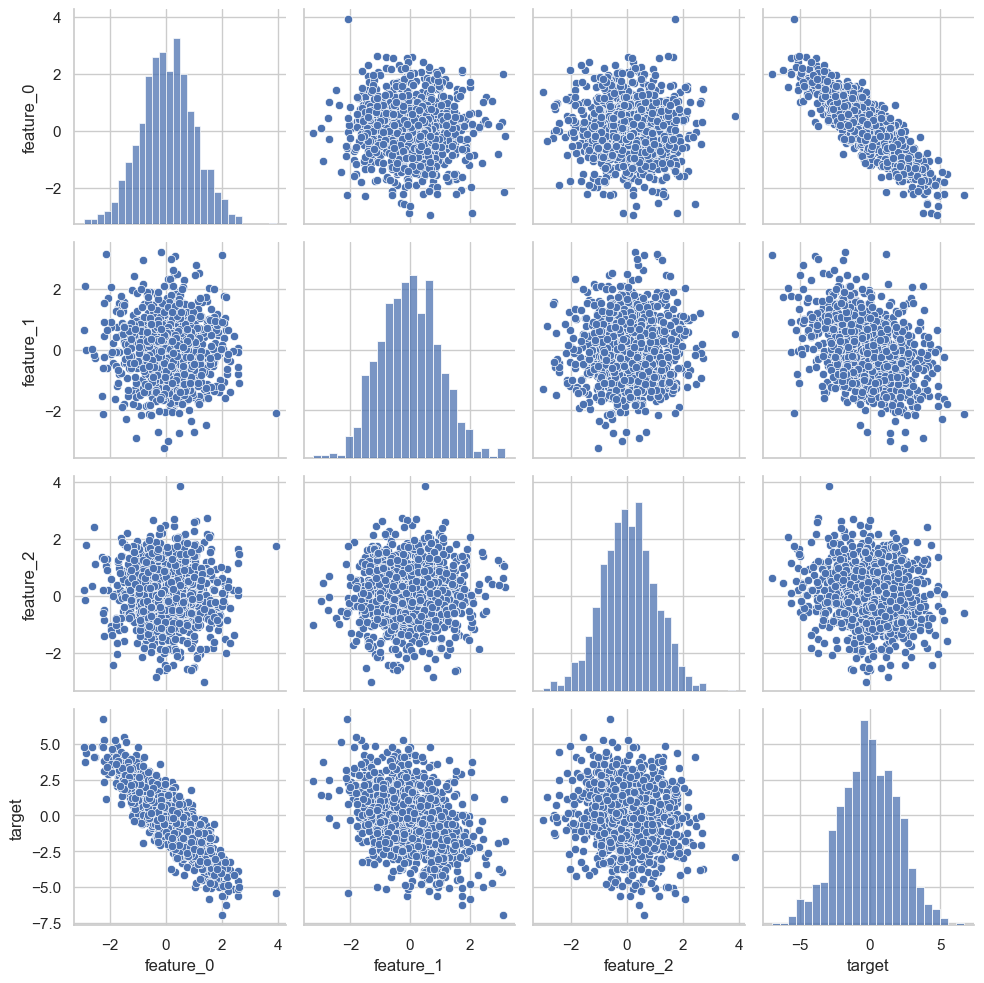

In [5]:
# Pairplot to visualize relationships between variables
sns.pairplot(data, height=2.5)
plt.tight_layout()

## Time Series Simulation

In [6]:
# Generate a time series with trend, seasonality, and noise
time_series = simulator.generate_time_series(
    n_points=730,  # 2 years of daily data
    trend=0.02,
    seasonality_amplitude=5.0,
    seasonality_period=365,
    noise=1.0
)

# Display the first few values
time_series.head()

2020-01-01    0.472630
2020-01-02   -1.260792
2020-01-03    0.804675
2020-01-04   -2.386293
2020-01-05   -0.205872
Freq: D, Name: value, dtype: float64

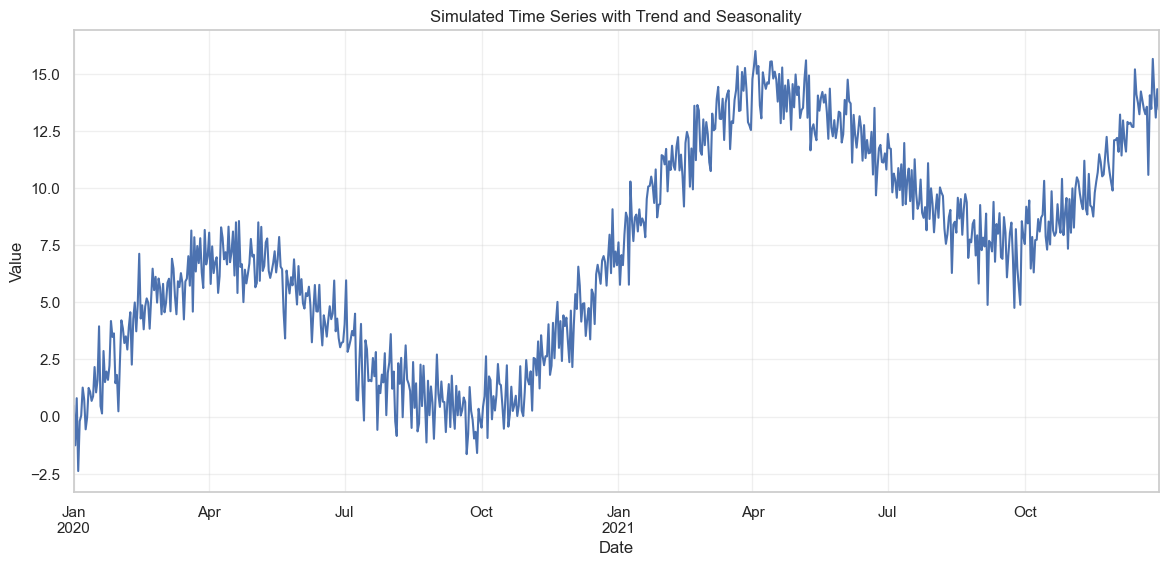

In [7]:
# Plot the time series
plt.figure(figsize=(14, 6))
time_series.plot()
plt.title('Simulated Time Series with Trend and Seasonality')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(alpha=0.3)
plt.show()

/var/folders/nr/d2nfxcd51h7443rmkccfw0_00000gn/T/ipykernel_9910/4185124193.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = time_series.resample('M').mean()


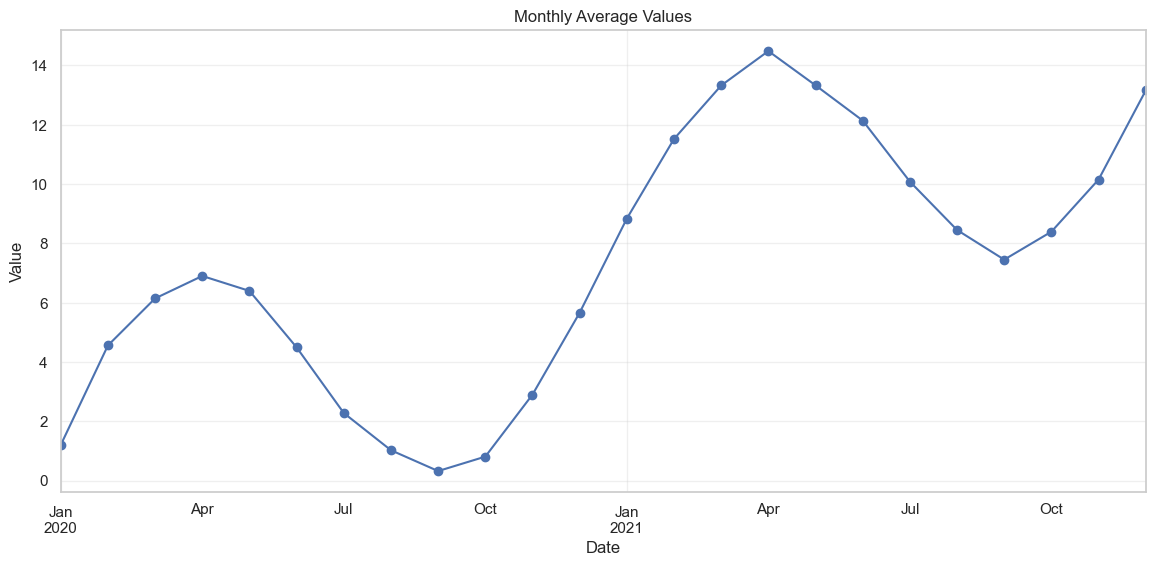

In [8]:
# Monthly averages to see seasonal patterns more clearly
monthly_avg = time_series.resample('M').mean()

plt.figure(figsize=(14, 6))
monthly_avg.plot(marker='o')
plt.title('Monthly Average Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Fix the warning in monthly resampling
monthly_avg = time_series.resample('ME').mean()

plt.figure(figsize=(14, 6))
monthly_avg.plot(marker='o')
plt.title('Monthly Average Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(alpha=0.3)
plt.show()

## Beta Parameter Optimizer

This section demonstrates how to use the `MLModelSimulator` from the beta_param_optimizer module.

In [ ]:
# Initialize the Beta Model Simulator
beta_simulator = MLModelSimulator(
    population_size=10000, 
    prevalence=0.05,  # 5% positive events 
    top_k=250         # Select top 250 as high risk
)

# Set target performance metrics
targets = PerformanceTargets(ppv=0.20, sensitivity=0.75)

print("=== Beta Distribution Optimizer ===")
print(f"Population size: {beta_simulator.population_size}")
print(f"Prevalence: {beta_simulator.prevalence:.1%}")
print(f"Top-k selection: {beta_simulator.top_k}")
print(f"Target PPV: {targets.ppv:.3f}")
print(f"Target Sensitivity: {targets.sensitivity:.3f}")
print()

In [ ]:
# Calibrate the model to achieve target performance metrics
print("Calibrating model...")
beta_params = beta_simulator.calibrate(targets)

print("\nOptimal Beta Parameters:")
print(beta_params)

In [ ]:
# Generate scores and validate performance
print("Generating scores and validating performance...")
scores, true_labels = beta_simulator.generate_scores()
performance = beta_simulator.validate_performance(scores, true_labels)

print(f"\nAchieved Performance:")
print(f"PPV: {performance['ppv']:.4f}")
print(f"Sensitivity: {performance['sensitivity']:.4f}")
print(f"Specificity: {performance['specificity']:.4f}")
print(f"F1 Score: {performance['f1_score']:.4f}")

In [ ]:
# Visualize the Beta distributions
beta_simulator.plot_distributions()

In [ ]:
# Let's create a DataFrame from the generated scores and labels
df_scores = pd.DataFrame({
    'score': scores,
    'is_positive': true_labels
})

# Examine the score distributions by true label
plt.figure(figsize=(12, 6))
sns.histplot(data=df_scores, x='score', hue='is_positive', bins=50, alpha=0.6)
plt.title('Risk Score Distribution by Actual Label')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Experiment with different target performance metrics
print("Experimenting with different target metrics...")

experiments = [
    PerformanceTargets(ppv=0.15, sensitivity=0.80),
    PerformanceTargets(ppv=0.25, sensitivity=0.60),
    PerformanceTargets(ppv=0.30, sensitivity=0.50)
]

results = []

for i, target in enumerate(experiments):
    print(f"\nExperiment {i+1}: PPV={target.ppv:.2f}, Sensitivity={target.sensitivity:.2f}")
    # Calibrate
    beta_params = beta_simulator.calibrate(target)
    # Generate and validate
    scores, labels = beta_simulator.generate_scores()
    perf = beta_simulator.validate_performance(scores, labels)
    
    results.append({
        'target_ppv': target.ppv,
        'target_sensitivity': target.sensitivity,
        'achieved_ppv': perf['ppv'],
        'achieved_sensitivity': perf['sensitivity'],
        'neg_alpha': beta_params.neg_alpha,
        'neg_beta': beta_params.neg_beta,
        'pos_alpha': beta_params.pos_alpha,
        'pos_beta': beta_params.pos_beta
    })
    
    print(f"Achieved: PPV={perf['ppv']:.4f}, Sensitivity={perf['sensitivity']:.4f}")

# Create a DataFrame with results
results_df = pd.DataFrame(results)
results_df